In [82]:
import torch
import torch.nn as nn
import torchvision as tv
from torch.utils.data import DataLoader

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from typing import Tuple, List

%matplotlib inline

In [2]:
def get_mnist_ds(is_train:bool):
    return tv.datasets.MNIST(root = Path('mnistdata'),
                             train = is_train,
                             transform = tv.transforms.ToTensor(),
                             target_transform = None,
                             download = True
                            )

In [83]:
def get_mnist_ds_loader(batch_size):
        train_ds = get_mnist_ds(is_train = True)
        valid_ds = get_mnist_ds(is_train = False)
        
        return (DataLoader(train_ds, batch_size, shuffle = True),
                DataLoader(valid_ds, 2*batch_size, shuffle = False))
    

In [4]:
train_dl, valid_dl = get_mnist_ds_loader(32)

In [5]:
len(train_dl.dataset), len(valid_dl.dataset)

(60000, 10000)

In [6]:
train_dl.dataset.data.shape

torch.Size([60000, 28, 28])

torch.Size([32, 1, 28, 28])
torch.Size([32])


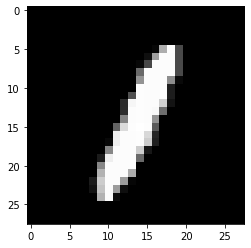

torch.Size([32, 1, 28, 28])
torch.Size([32])


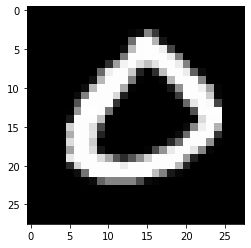

torch.Size([32, 1, 28, 28])
torch.Size([32])


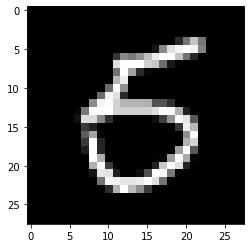

torch.Size([32, 1, 28, 28])
torch.Size([32])


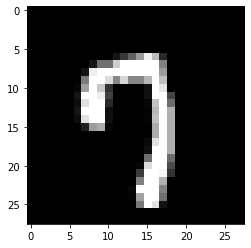

torch.Size([32, 1, 28, 28])
torch.Size([32])


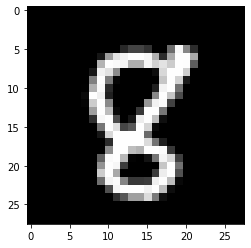

In [7]:
for i, x in enumerate(train_dl):
    print(x[0].shape)
    print(x[1].shape)
    plt.imshow(x[0][0][0],cmap='gray')
    plt.show()
    if i>3 : break

In [8]:
class Encoder(nn.Module):
    def __init__(self, inp_size: Tuple[int,int], hidden_size: int, out_size: int):
        
        super().__init__()
        
        self.enc = nn.Sequential(nn.Flatten(),
                                 nn.Linear(np.prod(inp_size), hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, out_size))
        
    def forward(self, x):
        return self.enc(x)
        

In [9]:
class Decoder(nn.Module):
    def __init__(self, inp_size: int, hidden_size: int, out_size: Tuple[int,int]):
        
        super().__init__()
        self.out_size = out_size
        self.dec = nn.Sequential(nn.Linear(inp_size, hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, np.prod(out_size)),
                                 nn.Sigmoid())
        
    def forward(self, x):
        x = self.dec(x)
        return x.view((x.shape[0],1,*self.out_size))

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self, inp_size: Tuple[int,int], hidden_size: int, out_size: int):
        super().__init__()
        
        self.enc = Encoder(inp_size, hidden_size, out_size)
        self.dec = Decoder(out_size, hidden_size, inp_size)
        
    def forward(self, x):
        out = self.enc(x)
        out = self.dec(out)
        
        return out

In [11]:
ae = AutoEncoder(inp_size=(28,28),hidden_size=512,out_size=20)

In [12]:
x = valid_dl.dataset[0][0]

In [13]:
x.shape

torch.Size([1, 28, 28])

In [14]:
out = ae(x)

In [15]:
out.shape

torch.Size([1, 1, 28, 28])

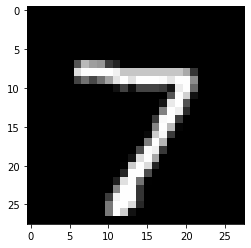

In [16]:
plt.imshow(x[0], cmap='gray')

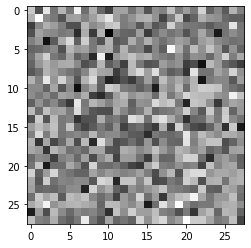

In [17]:
plt.imshow(out[0][0].detach().numpy(),cmap='gray')

In [18]:
ae

AutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=20, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=20, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)

In [56]:
iterat = valid_dl.__iter__()

In [57]:
curr_mini_batch = iterat.next()

In [81]:
print(type(curr_mini_batch))

<class 'list'>


In [59]:
curr_mini_batch[0].shape

torch.Size([64, 1, 28, 28])

In [61]:
grid = tv.utils.make_grid(curr_mini_batch[0], nrow=8, padding=2)

In [62]:
grid_1 = grid.permute(1,2,0)

In [63]:
print(grid.shape, grid.stride(), grid.data_ptr())
print(grid_1.shape, grid_1.stride(), grid_1.data_ptr())

torch.Size([3, 242, 242]) (58564, 242, 1) 94380178269632
torch.Size([242, 242, 3]) (242, 1, 58564) 94380178269632


In [64]:
out = ae(curr_mini_batch[0])

In [65]:
print(curr_mini_batch[0].shape, out.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])


In [66]:
len([*curr_mini_batch[0],*out])

128

In [36]:
elem_num = 10

In [70]:
ae.eval()

AutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=20, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=20, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)

In [67]:
actuals_elems = curr_mini_batch[0][0:elem_num,:,:,:]

In [76]:
with torch.no_grad():
    reconst_elems = ae(actuals_elems).detach()
ae.train()

AutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=20, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=20, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)

In [77]:
grid_elems = [*actuals_elems, *reconst_elems]

In [78]:
grid = tv.utils.make_grid(grid_elems, nrow=elem_num, padding=1, pad_value =1).permute(1,2,0)

In [79]:
grid.shape

torch.Size([59, 291, 3])

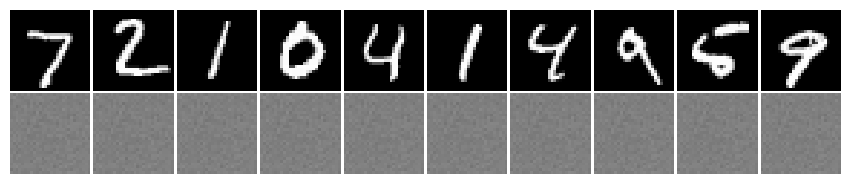

In [80]:
plt.figure(figsize=(15,15))
plt.imshow(grid)
plt.axis('off')
plt.show()

In [103]:
torch.cat((valid_dl.dataset[0][0].unsqueeze(dim=0),))

torch.Size([2, 1, 28, 28])

In [ ]:
def show_summary(valid_dl: DataLoader, model: nn.Module):
    ELEM_NUM = 10
    
    ae.eval()
    actuals_elems = 